<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_cnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Environment Prep

### Package Import

In [0]:
import imageio
import imgaug as ia

import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')
#!{sys.executable} -m pip install opencv-python

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
#from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import keras_metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications.resnet import ResNet50
from keras.callbacks import CSVLogger

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
#from tensorflow.keras import get_default_graph

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This code has been tested with TensorFlow 1.6
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(123)

# Transfer learning with VGG16
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
import seaborn as sns

from numpy import loadtxt
from keras.models import load_model

Using TensorFlow backend.


### Functions

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

## Data Prep

### Data import

In [0]:
%cd RxID2/Notebooks

/home/jupyter/RxID2/Notebooks


In [0]:
df = pd.read_csv('../Data/rxid15.csv')
df

,Unnamed: 0,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
0,2946,9033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.JPG,.CR2,90331
1,2947,9033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.JPG,.CR2,90331
2,2949,9033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,90331
3,2950,9033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,90331
4,2951,9033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,90331
...,...,...,...,...,...,...,...,...,...,...,...
602,127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.JPG,.PNG,681800479
603,127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.JPG,.PNG,681800479
604,127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.JPG,.PNG,681800479
605,127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.JPG,.PNG,681800479


In [0]:
data ='RxID/Data/RxID2_split'
test_folder = '../Data/RxID2_split/test'
train_folder = '../Data/RxID2_split/train'
val_folder = '../Data/RxID2_split/validation'

# baseline model - 0.70

In [0]:
%pwd

'/home/jupyter/RxID2/Notebooks'

In [0]:
%cd Notebooks

/home/jupyter/RxID2/Notebooks


In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 28 
EPOCHS = 15
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                    ).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)
labels = list((val_generator.class_indices).values())

Found 71 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [0]:
model = models.Sequential(name='model1-baseline')

model.add(layers.Conv2D(128, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3))) 

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

csv_logger = CSVLogger('../hist{}.log'.format(model.name), separator=',', append=False)
checkpoint = ModelCheckpoint("{}.h5".format(model.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

Model: "model1-baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                61455     
Total params: 138,831
Trainable params: 138,831
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                    callbacks=[checkpoint,early,csv_logger],
                    #workers=-1,
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/15
 9/10 [==========================>...] - ETA: 8s - loss: 2.6648 - acc: 0.1319 

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py", line 406, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.7/multiprocessi

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cf76cfb1af57>", line 9, in <module>
    verbose=1)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1147, in fit
    initial_epoch=initial_epoch)
  File "/opt/conda/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training_generator.py", line 185, in fit_generator
    generator_output = next(output_generator)
  File "/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py", line 610, in get
    inputs = future.get(timeout=30)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py

KeyboardInterrupt: 

# Analysis

In [0]:
model = load_model('../model1-baseline.h5')
model.summary()

Model: "model1-baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                61455     
Total params: 138,831
Trainable params: 138,831
Non-trainable params: 0
_________________________________________________________________


In [0]:
val_generator.samples

75

In [0]:
class_size =  int(val_generator.samples / len(val_generator.class_indices))

In [0]:
hist = pd.read_csv('../histmodel1-baseline.log', sep=',', engine='python',)

In [0]:
model_val_results = model.evaluate(val_generator,workers= -1)
model_val_results

3/3 [==============================] - 10s 3s/step


[2.005049705505371, 0.5600000023841858]

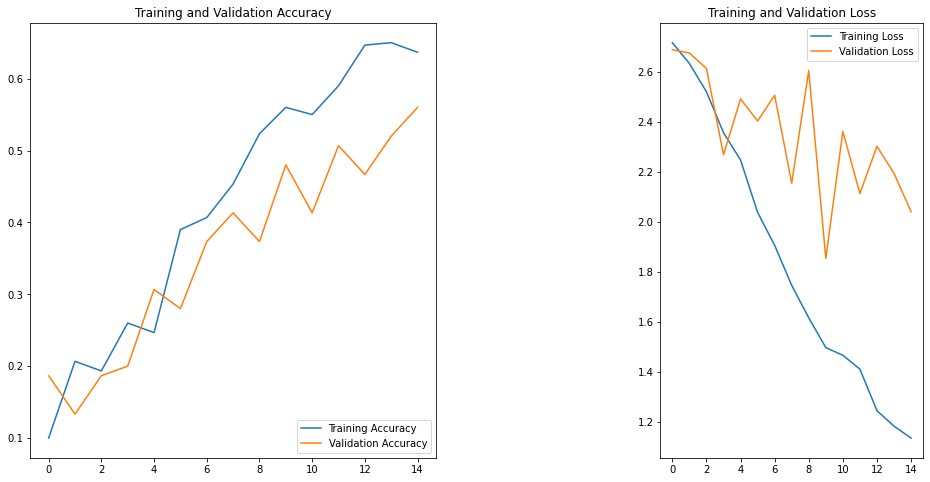

In [0]:
acc = hist['acc']
val_acc = hist['val_acc']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('{}_AccLoss.png'.format(model.name))
plt.show()

No handles with labels found to put in legend.


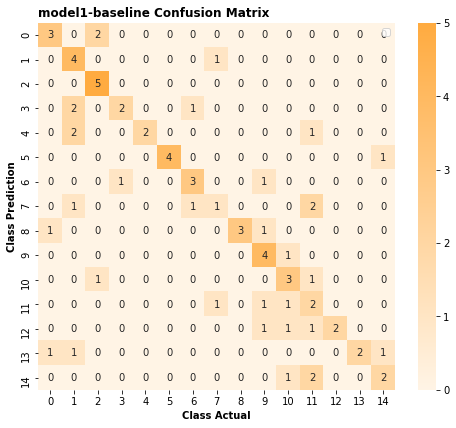

In [0]:
labels = list((val_generator.class_indices).values())
pred = model.predict(val_generator)
y_pred=np.argmax(pred,axis=1)
y_true = val_generator.classes

cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8,6.75))  
pal = sns.light_palette("#ffab40", as_cmap=True)
sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
plt.ylabel('Class Prediction', fontweight='bold')
plt.xlabel('Class Actual', fontweight='bold')
plt.title('{} Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
plt.legend()
plt.savefig('{}_conf'.format(model.name))

In [0]:
%cd ../Data/Download

/home/jupyter/RxID2/Data/Download


In [0]:
dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2'] # MC_API_RXNAV_V1.3
samplesdfx = dfx.groupby(['NDC']).max().reset_index()
sampleslist2 = samplesdfx.FILE.tolist()
#len(sampleslist2)

samplefiles = []
for image in sampleslist2:
    smplsplt = image.split('/')
    keep = smplsplt[-1]
    keep = keep[:-4]
    keep= keep +('.JPG')
    samplefiles.append(keep)

    
#for file in os.listdir():
drgimg = os.listdir()
images = []
for file in samplefiles:
    data = plt.imread(file)
    images.append(data)

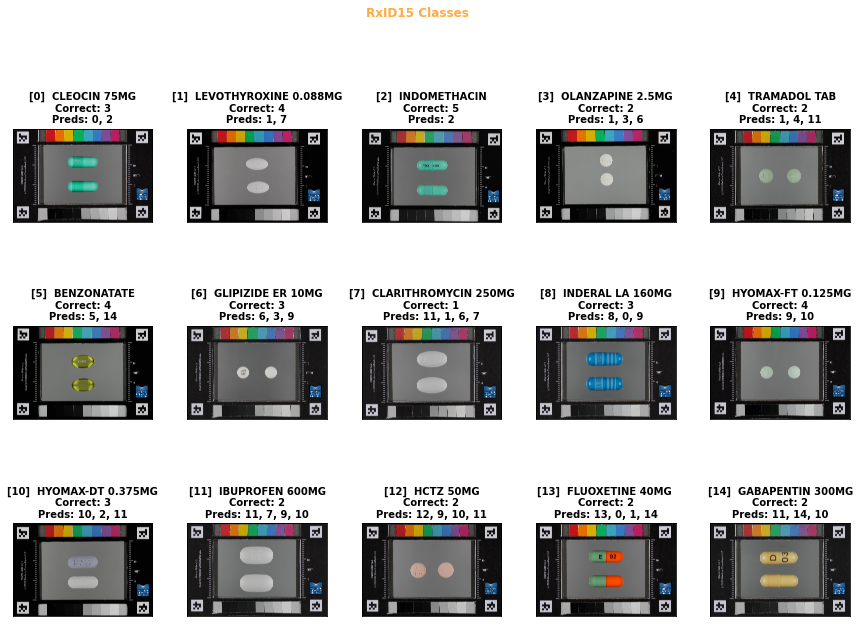

In [0]:
plt.figure(figsize=(15,15))
columns = 5
for i, image in enumerate(images): # iterate through the images in the array 'images'
    k = i * class_size
    j = (i + 1) * class_size
    trues = int(y_true[k:j].mean())
    preds = list(y_pred[k:j]).count(trues)
    #print(trues,preds)
    lst = list(y_pred[k:j])
    preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
    for pred in lst:
        preddict[pred] +=1
    preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
    for k, v in list(preddict.items()):
        if v == 0:
            del preddict[k]
    predlist = list(preddict.keys())
    #predmost = list(set(lst))
    dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
    dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
    title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
    plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
    #plt.margins(tight=True) # not sure which margins this is impacting
    plt.title(title,fontweight='semibold',fontsize='10')
    plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    #plt.savefig('../../Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...

In [0]:
i * class_size

0.0

In [0]:
y_true

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14], dtype=int32)